# Part I - NFL Big Data Bowl 2022
## by David Krejcarek

## Introduction

Before National Football League (NFL) coaches celebrate a big W, they strategize ways to improve field position and score points. Both of these objectives receive significant contributions from special teams plays, which consist of punts, kickoffs, field goals and extra points. These play types take on important roles in a game’s final score—so much so that coaches say they're a third of the game. Yet special teams remain an understudied part of American football, with an opportunity for data science to offer better ways to understand its impact.

The 2022 Big Data Bowl creates the opportunity for you (and the world!) to learn more about special teams play than ever before. We've provided the NFL's Next Gen Stats (NGS) tracking data from all 2018-2020 special teams plays. This data provides location information for each special teams player, wherever they are on the field, and includes their speed, acceleration, and direction. Additionally, and for the first time in Big Data Bowl history, participants can utilize scouting data from PFF, which supplements the tracking data with football specific metrics that coaches find critical to team success.

The NFL is America's most popular sports league. Founded in 1920, the organization behind American football has developed the model for the successful modern sports league. They're committed to advancing every aspect of the game, including the lesser researched special teams. In this competition, you’ll quantify what happens on special teams plays. You might create a new special teams metric, quantify team or individual strategies, rank players, or even something we haven’t considered.

With your creativity and analytical skills, the development of these new methods could lead to additional stats for special teams plays. If successful, your effort may even be adopted by the NFL for on air distribution, and you can watch future games knowing you had a hand in improving America's most popular sports league.

Summary of data
The 2022 Big Data Bowl data contains Next Gen Stats player tracking, play, game, player, and PFF scouting data for all 2018-2020 Special Teams plays. Here, you'll find a summary of each data set in the 2022 Data Bowl, a list of key variables to join on, and a description of each variable.

## Preliminary Wrangling


In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

> Load in your dataset and describe its properties through the questions below. Try and motivate your exploration goals through this section.


In [5]:
# Load three data bases
games = pd.read_csv(os.path.join('data', 'games.csv'))
players = pd.read_csv(os.path.join('data', 'players.csv'))
plays = pd.read_csv(os.path.join('data', 'plays.csv'))
pff = pd.read_csv(os.path.join('data', 'PFFScoutingData.csv'))

In [7]:
print(games.shape)
print(players.shape)
print(plays.shape)
print(pff.shape)

(764, 7)
(2732, 7)
(19979, 25)
(19979, 20)


In [15]:
# Some standard variables
BASE_COLOR = sb.color_palette()[0]

### What is the structure of your dataset?

> There are three seperate tables:
    Game data: The games.csv contains the teams playing in each game. The key variable is gameId.  This contains 764 rows with 7 columns

> Play data: The plays.csv file contains play-level information from each game. The key variables are gameId and playId. Contains a total 19,979 rows with 25 columns

> Player data: The players.csv file contains player-level information from players that participated in any of the tracking data files. The key variable is nflId. Contains 2,732 rows with 7 columns

### What is/are the main feature(s) of interest in your dataset?

> Is there a spefic feature of a kick off return player that makes them ideal to be a good returner
> 

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> Determine which player is has the most return yards, most return yards per return.
> Will need to see if there is a feature that is common among the top returners.
> Will need to see if there is a difference in returns yard as a season progresses.  
> Does a specific style contrbute to the returners success or failure.

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.


> **Rubric Tip**: The project (Parts I alone) should have at least 15 visualizations distributed over univariate, bivariate, and multivariate plots to explore many relationships in the data set.  Use reasoning to justify the flow of the exploration.



>**Rubric Tip**: Use the "Question-Visualization-Observations" framework  throughout the exploration. This framework involves **asking a question from the data, creating a visualization to find answers, and then recording observations after each visualisation.** 


In [37]:
# Determine which player has the most return yards
# Filter to only Kickoff and punt to determine return yards only
play_type = ['Kickoff', 'Punt']
plays_returnable = plays[plays['specialTeamsPlayType'].isin(play_type)]

# Confrim it worked
print('Values of Play Type')
print(plays_returnable.specialTeamsPlayType.value_counts())
print('Values of Play Results')
print(plays_returnable.specialTeamsResult.value_counts())

Values of Play Type
Kickoff    7843
Punt       5991
Name: specialTeamsPlayType, dtype: int64
Values of Play Results
Return                      5207
Touchback                   5156
Fair Catch                  1645
Downed                       833
Out of Bounds                650
Muffed                       214
Non-Special Teams Result      74
Blocked Punt                  39
Kickoff Team Recovery         16
Name: specialTeamsResult, dtype: int64


''

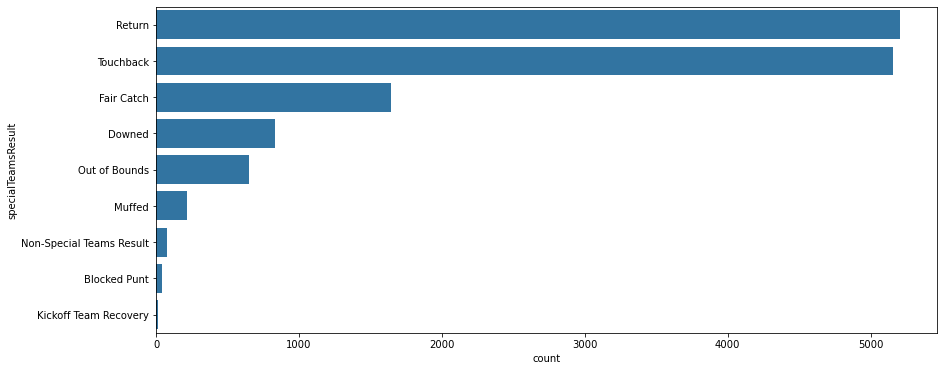

In [28]:
# Display the results of these kicks, this is a categorical element so a bar chart would be appropiate
plt.figure(figsize=[14,6])
sb.countplot(y =plays_returnable['specialTeamsResult'], color=BASE_COLOR, order=plays_returnable.specialTeamsResult.value_counts().index)
;

The intial review of the the play type results of kickpff and returns shows that the majority of the Results appears to be a return followed by a touchback.  This would be an interesting to see of this has changed over the course of the seasons.  And also what the diffence is between kick off and punts

In [38]:
# add on the season to the dataset
plays_returnable = plays_returnable.merge(games, on = 'gameId', how='left')
plays_returnable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13834 entries, 0 to 13833
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gameId                  13834 non-null  int64  
 1   playId                  13834 non-null  int64  
 2   playDescription         13834 non-null  object 
 3   quarter                 13834 non-null  int64  
 4   down                    13834 non-null  int64  
 5   yardsToGo               13834 non-null  int64  
 6   possessionTeam          13834 non-null  object 
 7   specialTeamsPlayType    13834 non-null  object 
 8   specialTeamsResult      13834 non-null  object 
 9   kickerId                13760 non-null  float64
 10  returnerId              6936 non-null   object 
 11  kickBlockerId           39 non-null     float64
 12  yardlineSide            13668 non-null  object 
 13  yardlineNumber          13834 non-null  int64  
 14  gameClock               13834 non-null

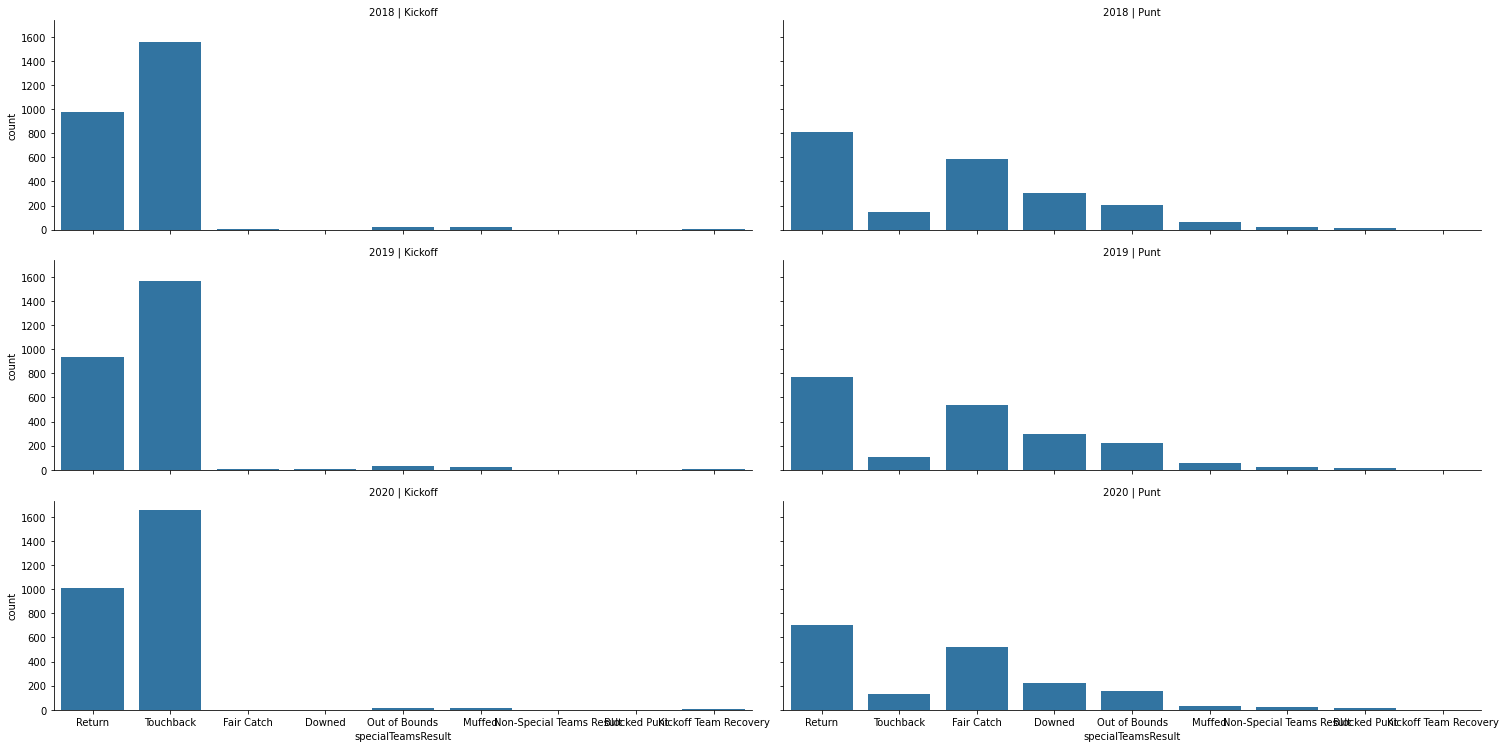

In [60]:
# Display the play results based on the season (Row) and also on the type (col)
order = plays_returnable.specialTeamsResult.value_counts().index
g = sb.FacetGrid(data = plays_returnable, row = 'season', col = 'specialTeamsPlayType', height=3.5, aspect=3)
g.map(sb.countplot, 'specialTeamsResult', orient = 'h', color=BASE_COLOR, order = order );
g.set_titles(col_template = '{col_name}', row_template='{row_name}');

When can see that using the two returnable type of kicks, kickoffs and punts, we can see that most lickely result will be a touch back followed by a return.  While a punt the most likely response will be a return followed by a fair catch.  We can also see by this data that it looks like the this breakdown is consistant over the course of the last three season.  



>**Rubric Tip**: Visualizations should depict the data appropriately so that the plots are easily interpretable. You should choose an appropriate plot type, data encodings, and formatting as needed. The formatting may include setting/adding the title, labels, legend, and comments. Also, do not overplot or incorrectly plot ordinal data.

C:\Users\dkrejcarek\Anaconda3\envs\Data Analysis\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


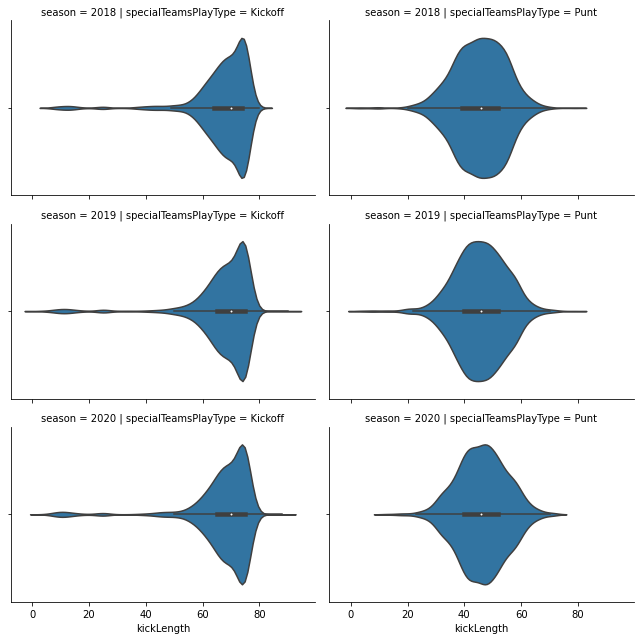

In [71]:
g = sb.FacetGrid(data = plays_returnable, col = 'specialTeamsPlayType', row = 'season', aspect=1.5)
g.map(sb.violinplot, 'kickLength');


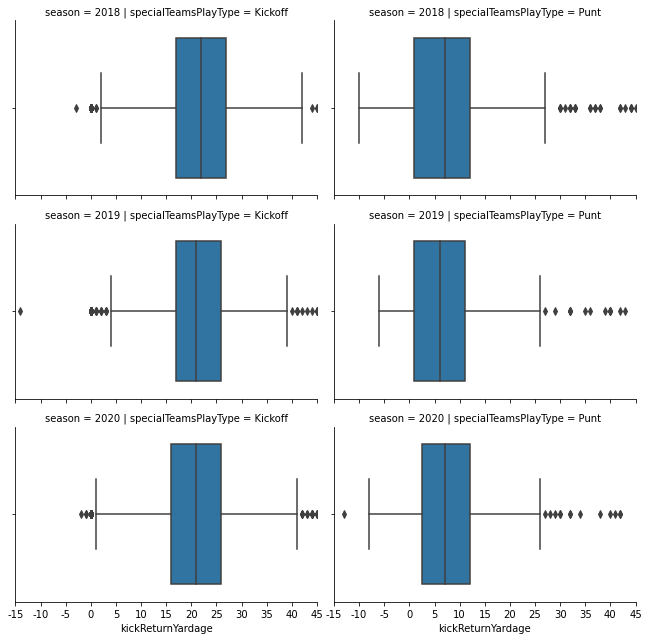

In [214]:
g = sb.FacetGrid(data = plays_returnable, col = 'specialTeamsPlayType', row = 'season', aspect = 1.5) # 
g.map(sb.boxplot, 'kickReturnYardage', order= ['2018', '2019', '2020'])
plt.xticks(np.arange(-15, 45+5, 5), np.arange(-15, 45+5, 5) )
plt.xlim(-15, 45);

Reviewing the kicklength and the return yards over the course of the last three seasons there appears to be a consistancy through each season.  This would would show that special teams have not improved on eather side of the ball.

Lets check on which player has the most returns and the most yards

In [171]:
# Get the names of the players
# Get names for labels

def name_labels(df, year):
    ''' Returns a list of names to use as axis labels '''
    top_ten_returners = plays_returnable.query('season == {}'.format(year)).returnerId.value_counts()[:10]

    new_labels = []
    for i in top_ten_returners.index:
        name = df[df['nflId'] == int(i)]['displayName'].values[0]
        new_labels.append(name)
    
    return new_labels



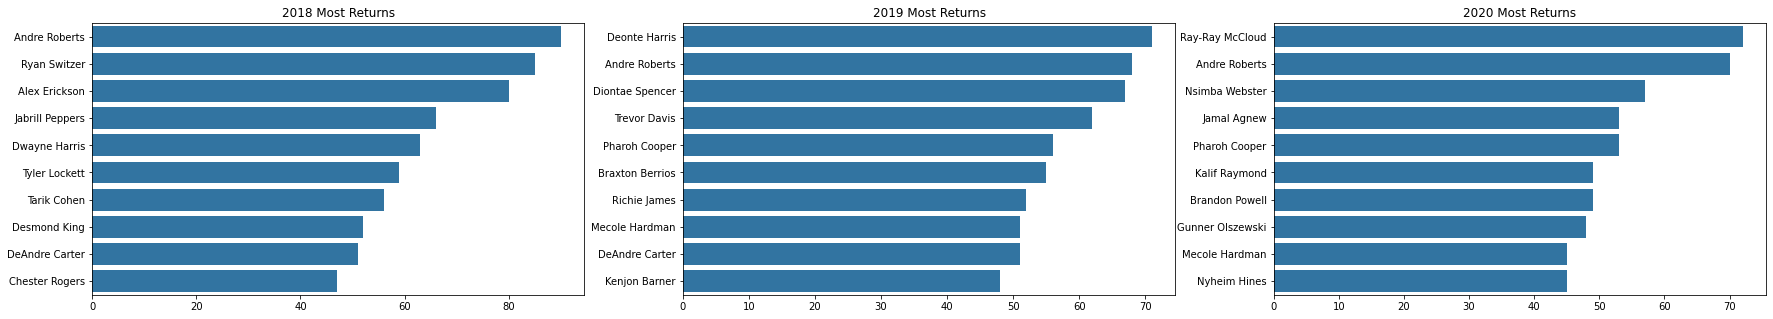

In [172]:
# Split the data into indivudual seasons
plt.figure(figsize=[30, 5])

# Plot the 2018 Season
plt.subplot(1, 3, 1)
plt.title('2018 Most Returns')
top_ten_returners_2018 =  plays_returnable.query('season == 2018').returnerId.value_counts()[:10]
sb.barplot(y = top_ten_returners_2018.index, x = top_ten_returners_2018.values, color = BASE_COLOR)
plt.yticks(np.arange(10), name_labels(players, 2018))

# Plot the 2019 Season
plt.subplot(1, 3, 2)
plt.title('2019 Most Returns')
top_ten_returners_2019 =  plays_returnable.query('season == 2019').returnerId.value_counts()[:10]
sb.barplot(y = top_ten_returners_2019.index, x = top_ten_returners_2019.values, color = BASE_COLOR)
plt.yticks(np.arange(10), name_labels(players, 2019))

# Plot the 2020 Season
plt.subplot(1, 3, 3)
plt.title('2020 Most Returns')
top_ten_returners_2020 =  plays_returnable.query('season == 2020').returnerId.value_counts()[:10]
sb.barplot(y = top_ten_returners_2020.index, x = top_ten_returners_2020.values, color = BASE_COLOR)
plt.yticks(np.arange(10), name_labels(players, 2020));

When we review the top ten returners over the 2018 thru 2020 season we can see that Andre Roberts was consistantly in the top two year over year in returns.  Being the bes tin 2018 and being second in the 2019 and 2020.  One intersesting to note that in 2018 the top three players all had over 80 reutrns, while int he next two years the max number of reutnrns was only in the low 70's.  Even though previosuly we showed that there wasn't an significant difference in the over all number of returnable kicks.  This is just the number of oppurtunities that a kick receiver had to return a kick.  The next item will be to see who has the most return yards and who has the most yards per return.

Total number of total return yards.  

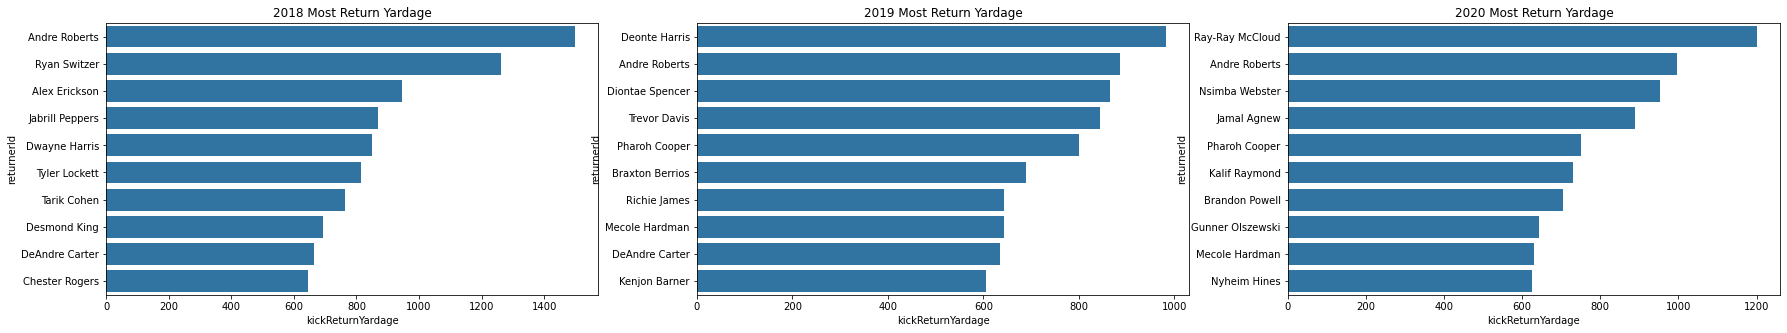

In [192]:
# Create a 3 wide bar plot of the top ten returners by yaradge
# Create a wide plot figure
plt.figure(figsize=[30,5])

seasons = [2018, 2019, 2020]  # TODO: Update this to be the index
plot = 1

for season in seasons: 
    plt.subplot(1, 3, plot)
    plot += 1 # moves the plot over one
    data = plays_returnable.query('season == {}'.format(season)).groupby('returnerId').sum().sort_values(by=['kickReturnYardage'], ascending=False)[:10]
    sb.barplot(y = data.index, x = data.kickReturnYardage, color=BASE_COLOR)
    plt.title('{} Most Return Yardage'.format(season))
    plt.yticks(np.arange(10), name_labels(players, season))
    


The top ten returners doesn't seem to change when looking at total yards instead of looking at the number of returns.  

Check to see if there is a difference in the yards oer return

In [248]:
# Determine the yards per return average by season

# Get the data for number of return counts
punt_return_counts = plays_returnable.query('season == 2018 & specialTeamsPlayType == "Punt"').returnerId.value_counts()
kickoff_return_counts = plays_returnable.query('season == 2018 & specialTeamsPlayType == "Kickoff"').returnerId.value_counts()
# get the the series for the total yards
punt_return_yards = plays_returnable.query('season == 2018 & specialTeamsPlayType == "Punt"').groupby('returnerId').sum()['kickReturnYardage']
kickoff_return_yards = plays_returnable.query('season == 2018 & specialTeamsPlayType == "Kickoff"').groupby('returnerId').sum()['kickReturnYardage']
# Create a dictionary for concatations
data = {'punt_return_yards': punt_return_yards,
        'punt_return_counts': punt_return_counts,
        'kickoff_return_yards': kickoff_return_yards,
        'kickoff_return_counts': kickoff_return_counts}

# Concat the two series into new datafra,e
returner_data = pd.concat(data, axis=1) 

# determine the yards per return
returner_data['punt_yard_per_return'] = returner_data['punt_return_yards'] / returner_data['punt_return_counts']
returner_data['kickoff_yard_per_return'] = returner_data['kickoff_return_yards'] / returner_data['kickoff_return_counts']


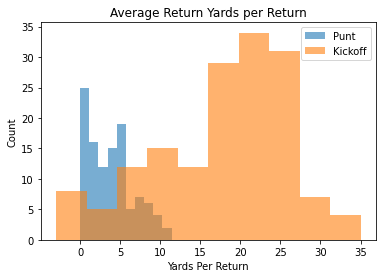

In [261]:
# g = sb.FacetGrid(data = returner_data, hue = 'kickoff_yard_per_return')
# g.map(sb.displot, 'punt_yard_per_return')
plt.hist(returner_data['punt_yard_per_return'], alpha = .6, label='Punt')
plt.hist(returner_data['kickoff_yard_per_return'], alpha = .6, label = 'Kickoff')
plt.title('Average Return Yards per Return')
plt.xlabel('Yards Per Return')
plt.ylabel('Count')
plt.legend();


I first looked at the yards per return as a whole and looking at that distribution of the yard per return avergae it appears that there are two seperate peaks one at 5 yards and the at around 20 yards.  These two parts I beleive would be based on punt verus kickoff returns.  With that it made more sense that the data should seperated by kickoff and punts values so that it can be shown that there is a differnce.  

After adjusting the data to display the distribution of yards per return, we can see that there are indeed two sepearate peaks which coresonding to the punt and kickoff.  A kickoff return has a higher average per carry but it also is skewed to the left.  This makes perfect sense based on that typically a kickoff is a longer kick and has more room to return.  It is intresting to see that a touch back would give the returning team a starting ball positon of 25.  It would interesting to see what the starting yard line for kickoffs is and if there is even a benefit of returning a ball.  It could make sense for a team to never return a kickoff and always try to take a touchback.  There might also be a benefit for a kicking team to not kick the ball into the endzone and force a return to push the starting kickoff behind the 25 yardline.  

There is still two peaks in the punting, this would be makes sense that the top two results was Return or a Fair Catch.  The Fair catch would push the average down around zero and then a return it would appear that the average is 5 yards.  There is some room in this area to further dive into the this data and see of what factors of a kick contribute to a a fair catch versus what kick contri

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

## Conclusions
>You can write a summary of the main findings and reflect on the steps taken during the data exploration.



> Remove all Tips mentioned above, before you convert this notebook to PDF/HTML


> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML or PDF` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!

